In [1]:
from obspy.clients.fdsn import Client
client = Client("IRIS")

In [ ]:
from obspy import UTCDateTime
t = UTCDateTime("2010-02-27T06:30:00")
st = client.get_waveforms("IU", "ANMO", "00", "BH1", t, "2010-02-27T10:30:00")
st.plot()  

## Abordagem Promissora

In [241]:
from obspy.clients import fdsn
from obspy import UTCDateTime
from obspy.core.util import AttribDict
from obspy.geodetics.base import gps2dist_azimuth
import matplotlib.pyplot as plt

start = '2015-06-29T01:00:00.0'
end = '2015-06-29T09:00:00.0'

# Use ph5ws-station to retrieve ZI (15-016) station metadata
STATION = 'http://service.iris.edu/ph5ws/station/1'
c = fdsn.client.Client(
                       service_mappings={
                           'station': STATION
                       },
                       debug=True
                      )
inventory = c.get_stations(network='ZI', station='*', 
                    location='--', channel='DPZ', arrayid='001',
                    level='response',
                    starttime=UTCDateTime(start),
                    endtime=UTCDateTime(end))

# Use ph5ws-event to retrieve ZI (15-016) event 5013 metadata
EVENT = 'http://service.iris.edu/ph5ws/event/1'
c = fdsn.client.Client(
                       service_mappings={
                           'event': EVENT
                       },
                       debug=True
                      )
events = c.get_events(catalog='ZI',
                      starttime=UTCDateTime(start),
                      endtime=UTCDateTime(end),
                      shotline='001',
                      shotid='5013')

# Use ph5ws-dataselect to retrieve ZI (15-016) waveform data
DATASELECT = 'http://service.iris.edu/ph5ws/dataselect/1'
c = fdsn.client.Client(
               service_mappings={
                   'dataselect': DATASELECT
               },
               debug=True
              )
# Request the first 60 seconds of data immediately following 
# the shot. The "by shot" ph5ws-dataselect request type 
# option can be used as an alternative to manual windowing.
stream = c.get_waveforms(network='ZI', station='*', 
                        location='--', channel='DPZ',
                        starttime=events[0].origins[0].time,
                        endtime=events[0].origins[0].time+60)
stream.attach_response(inventory)

# Compute the distance from the source for each channel
for trace in stream:
    for station in inventory[0]:
        for channel in station:
            if trace.stats.station == station.code and \
               trace.stats.location == channel.location_code and \
               trace.stats.channel == channel.code:
                trace.stats.coordinates = AttribDict(
                                            {'latitude': channel.latitude, 
                                             'longitude': channel.longitude})
                trace.stats.distance = gps2dist_azimuth(
                                            events[0].origins[0].latitude, 
                                            events[0].origins[0].longitude, 
                                            channel.latitude, 
                                            channel.longitude)[0]

Installed new opener with handlers: [<obspy.clients.fdsn.client.CustomRedirectHandler object at 0x1195573c8>]
Base URL: http://service.iris.edu
Custom service mappings:
	station: 'http://service.iris.edu/ph5ws/station/1'
Request Headers: {'User-Agent': 'ObsPy/1.1.1 (Darwin-18.6.0-x86_64-i386-64bit, Python 3.6.8)'}
Loading discovered services from cache.
Uncompressing gzipped response for http://service.iris.edu/ph5ws/station/1/query?arrayid=001&starttime=2015-06-29T01%3A00%3A00.000000&endtime=2015-06-29T09%3A00%3A00.000000&network=ZI&station=%2A&location=--&channel=DPZ&level=response
Downloaded http://service.iris.edu/ph5ws/station/1/query?arrayid=001&starttime=2015-06-29T01%3A00%3A00.000000&endtime=2015-06-29T09%3A00%3A00.000000&network=ZI&station=%2A&location=--&channel=DPZ&level=response with HTTP code: 200
Installed new opener with handlers: [<obspy.clients.fdsn.client.CustomRedirectHandler object at 0x1266f1400>]
Base URL: http://service.iris.edu
Custom service mappings:
	event: '

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; u

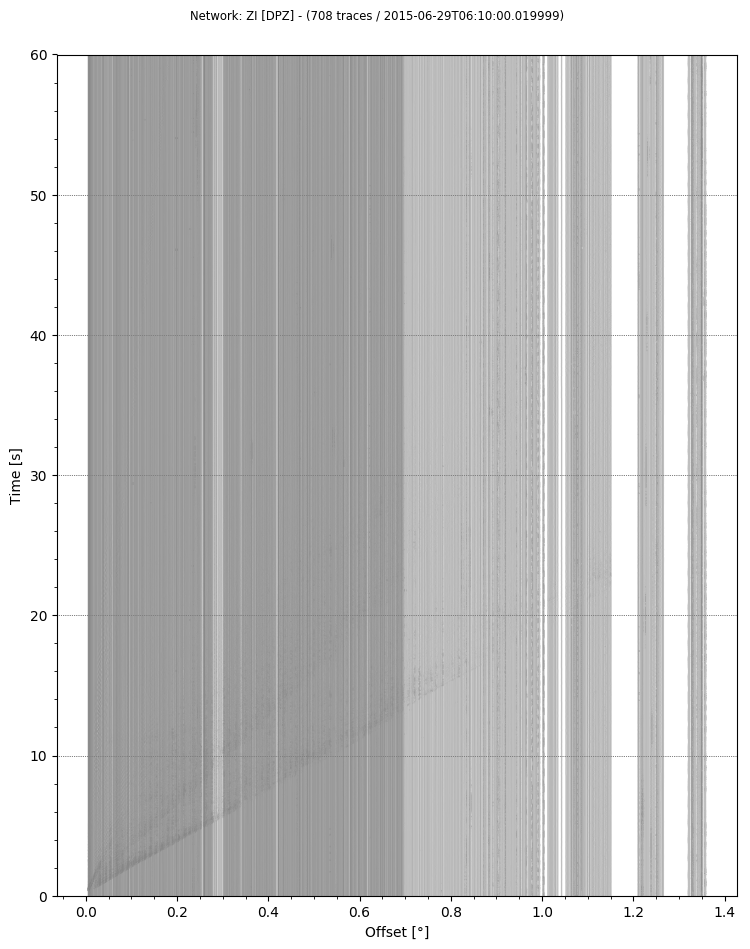

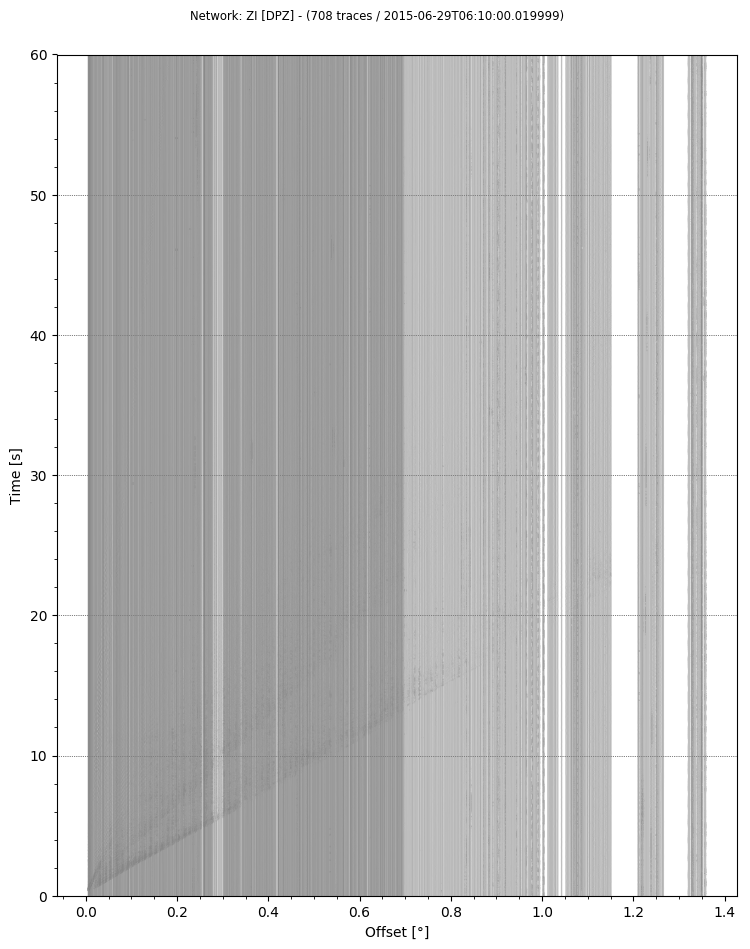

In [242]:
# Order the traces by distance from the source 
stream.traces.sort(key=lambda x: x.stats.distance)
# Plot the traces
stream.plot(type='section',
            color='gray',
            ev_coord=(events[0].origins[0].latitude, 
                      events[0].origins[0].longitude),
            dist_degree=True,
            size=(800, 1024))

## Transformar em Numpy Array

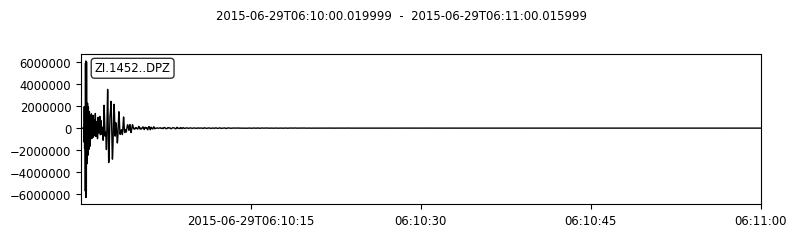

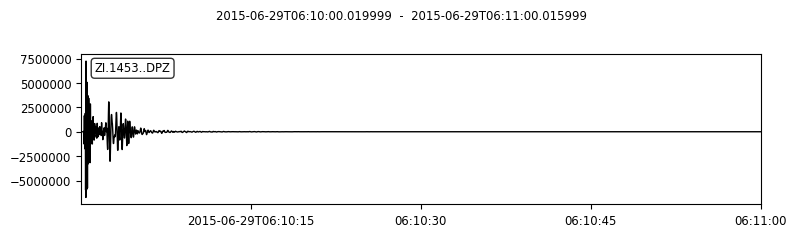

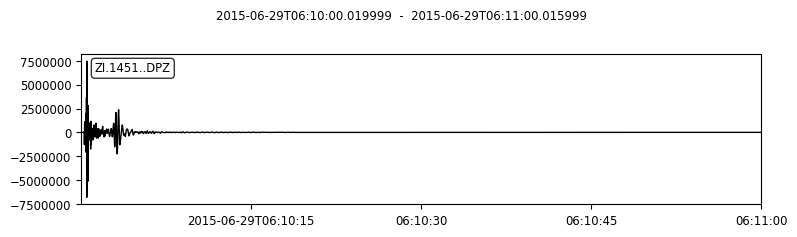

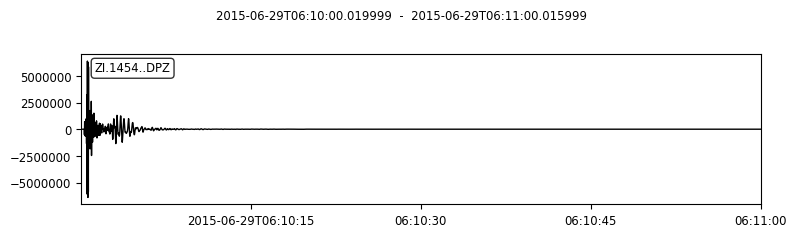

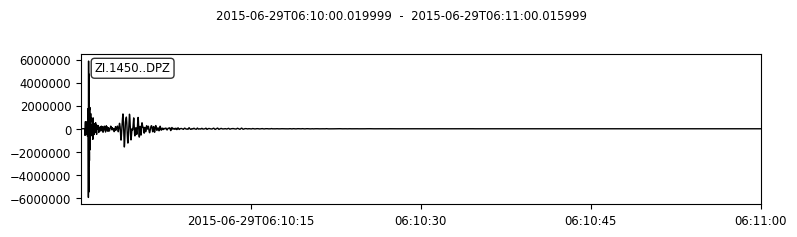

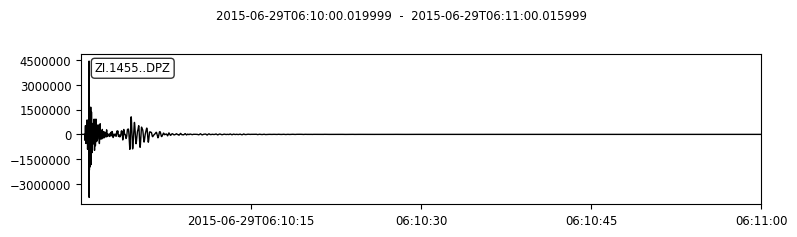

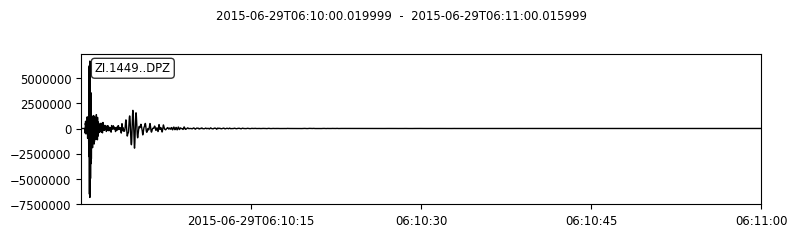

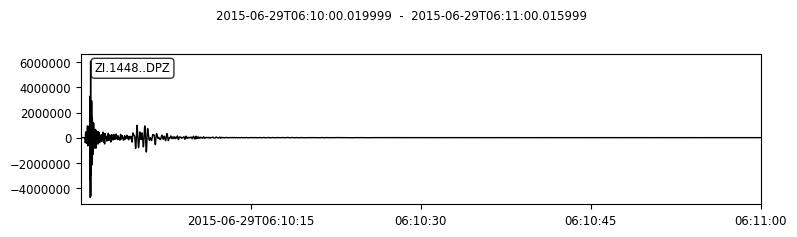

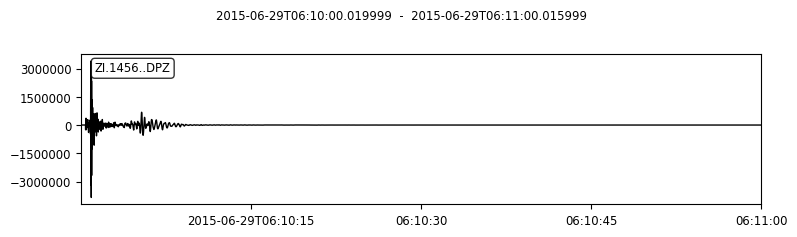

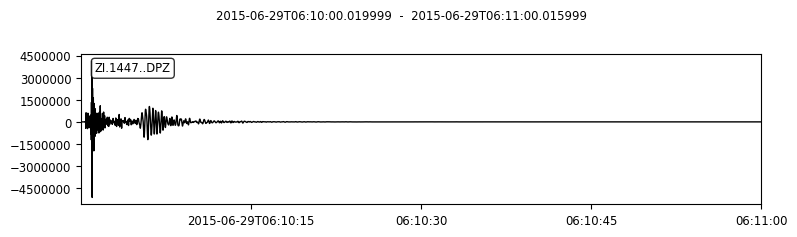

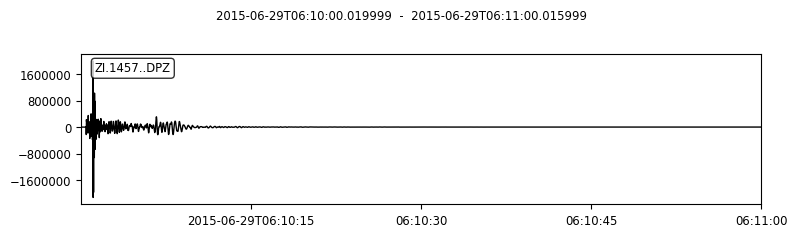

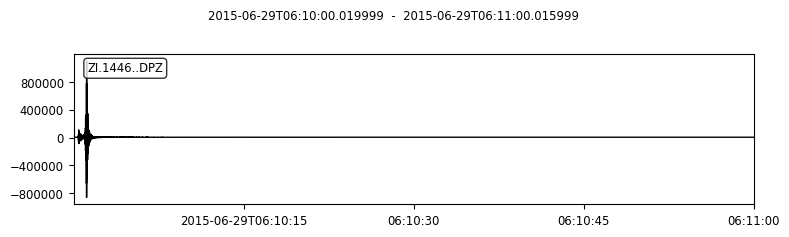

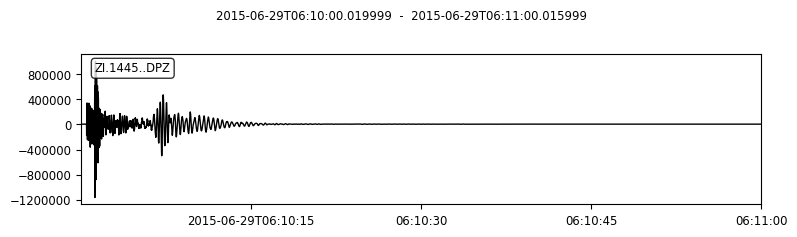

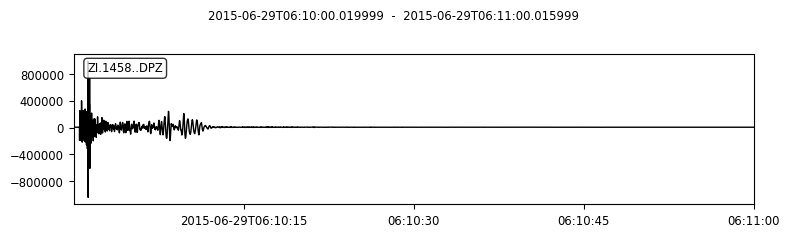

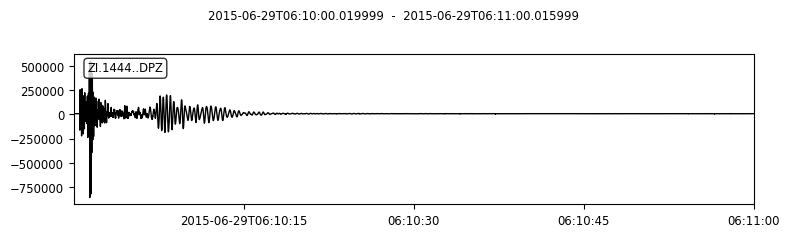

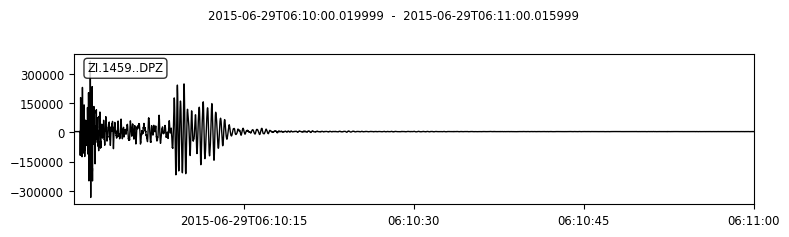

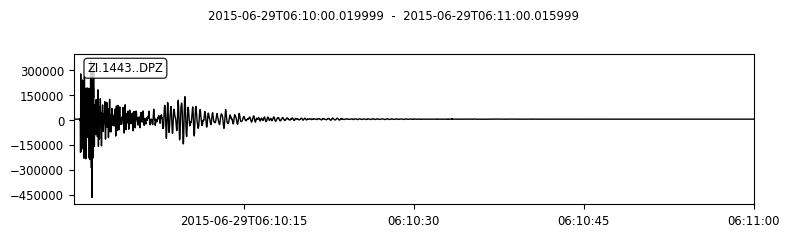

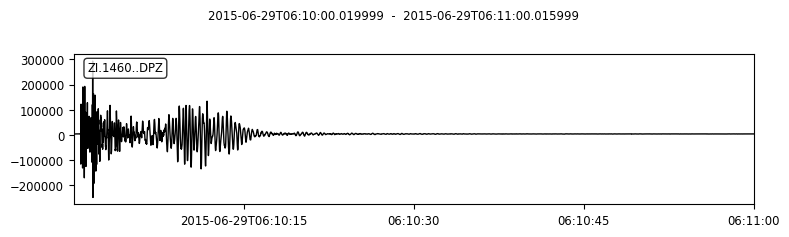

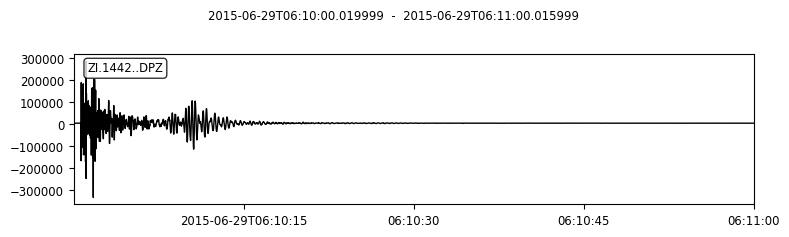

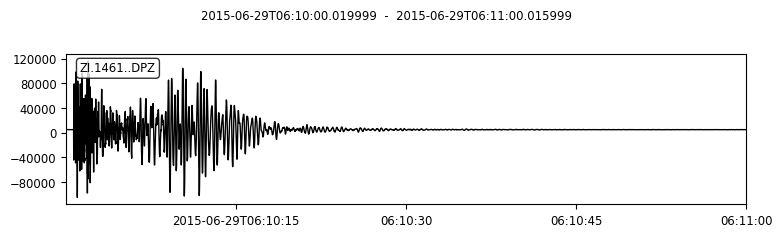

In [276]:
arr = []
for line in stream[:20]:
    line.plot()

In [257]:
import numpy as np
csg = np.array(arr)
csg.shape

(20, 3000)

In [258]:
csg

array([[  3737,   3717,   3679, ...,  -4973,  -5566,  -6355],
       [  3307,   3316,   3354, ..., -11891, -10155,  -8551],
       [  4394,   4313,   4400, ...,  19996,  19599,  18816],
       ..., 
       [  4370,   4320,   4276, ...,  63065,  63348,  62520],
       [  4404,   4410,   4427, ...,  11831,  11725,  11559],
       [  4853,   4883,   4888, ..., -55877, -58928, -61371]], dtype=int32)

In [247]:
csg.min(), csg.max()

(-6843843, 7470138)

In [259]:
norm = csg

In [260]:
norm = ( norm - norm.mean() ) / norm.std()

In [261]:
norm = norm*0.1+0.5

In [262]:
norm = np.clip(norm, 0, 1)

In [272]:
norm.shape

(20, 3000)

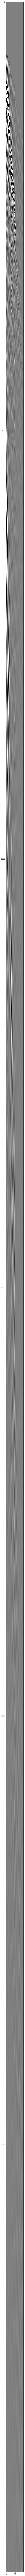

In [275]:
plt.figure(figsize=(20,300))
plt.imshow(np.transpose(norm), cmap='gray')#, vmin=norm.min(), vmax=norm.max() )

In [179]:
aux_csg = csg + csg.min()
#aux_csg = aux_csg/aux_csg.max()

In [199]:
norm.max()

114.80627152893146